# Wine Quality Regression practice

## Dataset

https://www.kaggle.com/uciml/red-wine-quality-cortez-et-al-2009


### Context 

This datasets is related to red variants of the Portuguese "Vinho Verde" wine. For more details, consult the reference [Cortez et al., 2009]. Due to privacy and logistic issues, only physicochemical (inputs) and sensory (the output) variables are available (e.g. there is no data about grape types, wine brand, wine selling price, etc.).

Tips

What might be an interesting thing to do, is aside from using regression modelling, is to set an arbitrary cutoff for your dependent variable (wine quality) at e.g. 7 or higher getting classified as 'good/1' and the remainder as 'not good/0'.
This allows you to practice with hyper parameter tuning on e.g. decision tree algorithms looking at the ROC curve and the AUC value.
Without doing any kind of feature engineering or overfitting you should be able to get an AUC of .88 (without even using random forest algorithm)

KNIME is a great tool (GUI) that can be used for this.

1 - File Reader (for csv) to linear correlation node and to interactive histogram for basic EDA.

2- File Reader to 'Rule Engine Node' to turn the 10 point scale to dichtome variable (good wine and rest), the code to put in the rule engine is something like this:

$quality$ > 6.5 => "good"
TRUE => "bad" 

3- Rule Engine Node output to input of Column Filter node to filter out your original 10point feature (this prevent leaking)

4- Column Filter Node output to input of Partitioning Node (your standard train/tes split, e.g. 75%/25%, choose 'random' or 'stratified')

5- Partitioning Node train data split output to input of Train data split to input Decision Tree Learner node and 

6- Partitioning Node test data split output to input Decision Tree predictor Node

7- Decision Tree learner Node output to input Decision Tree Node input

8- Decision Tree output to input ROC Node.. (here you can evaluate your model base on AUC value)



In [1]:
import pandas as pd
import explore
import feature_engineering
import split_scale
import model
import statsmodels.api as sm
import matplotlib.pyplot as plt 
from math import sqrt
from scipy import stats
from pydataset import data
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import explained_variance_score

import seaborn as sns
import evaluate
import sklearn.metrics

In [2]:
wines = pd.read_csv("wine-quality-red.csv")

In [3]:
wines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
fixed acidity           1599 non-null float64
volatile acidity        1599 non-null float64
citric acid             1599 non-null float64
residual sugar          1599 non-null float64
chlorides               1599 non-null float64
free sulfur dioxide     1599 non-null float64
total sulfur dioxide    1599 non-null float64
density                 1599 non-null float64
pH                      1599 non-null float64
sulphates               1599 non-null float64
alcohol                 1599 non-null float64
quality                 1599 non-null int64
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


Lucky, it seems there are no null values. Since the data comes from Kaggle, I will trust that it is clean data for now. 

We find that the data can use a little bit of feature engineering, as there is a relationship between `pH` and `fre.sulfur.dioxide`. If there is not enough $SO_2$ in wine then quality will deteriorate and higher `pH` require more `free.sulfur.dioxide`. 

In [4]:
wines["mso2"] = wines["free sulfur dioxide"] / (1 + 10** (wines.pH - 1.81))

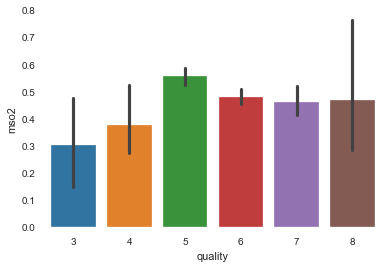

In [5]:
sns.barplot(data=wines, x="quality", y ="mso2")

As we can see, there seems to be a trend where poor quality wine has a lower $SO_2$, probably because the quality has degraded. Better wines seem to have a higher `mso2`, which makes sense as the expected value of `mso2` for red wine is between 0.4 and 0.6

## Split and Scale 

In [6]:
train, test = split_scale.split_my_df(wines)

In [7]:
X_train = train.drop(columns=["quality", "fixed acidity"])
y_train = train[["quality"]]
X_test = test.drop(columns=["quality", "fixed acidity"])
y_test = test[["quality"]]

In [8]:
train.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,mso2
1076,9.9,0.32,0.56,2.0,0.073,3.0,8.0,0.99534,3.15,0.73,11.4,6,0.131133
847,7.4,0.68,0.16,1.8,0.078,12.0,39.0,0.99770,3.50,0.70,9.9,6,0.240106
582,11.7,0.49,0.49,2.2,0.083,5.0,15.0,1.00000,3.19,0.43,9.2,5,0.200093
172,8.0,0.42,0.17,2.0,0.073,6.0,18.0,0.99720,3.29,0.61,9.2,6,0.192311
779,7.1,0.52,0.03,2.6,0.076,21.0,92.0,0.99745,3.50,0.60,9.8,5,0.420186


## Explore

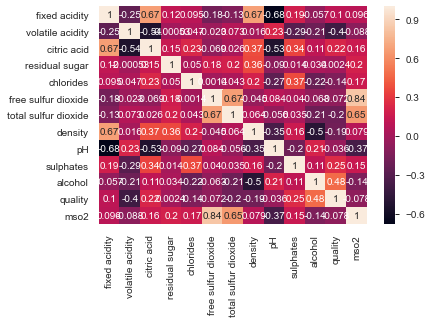

In [9]:
sns.heatmap(train.corr(), annot=True)

At this point, we notice that there are no variables that are highly correlated with our target variable. `alcohol` and `volatile acidity` seem to have the highest correlation. Luckuly, those two variables also don't seem to be too correlated with each other. 

In [10]:
train.corr().quality.sort_values()

volatile acidity       -0.399479
total sulfur dioxide   -0.201756
density                -0.186942
chlorides              -0.137099
mso2                   -0.077723
free sulfur dioxide    -0.072373
pH                     -0.035631
residual sugar          0.002350
fixed acidity           0.104519
citric acid             0.221081
sulphates               0.251701
alcohol                 0.479006
quality                 1.000000
Name: quality, dtype: float64

In [11]:
train.quality.describe()

count    1279.000000
mean        5.631744
std         0.805668
min         3.000000
25%         5.000000
50%         6.000000
75%         6.000000
max         8.000000
Name: quality, dtype: float64

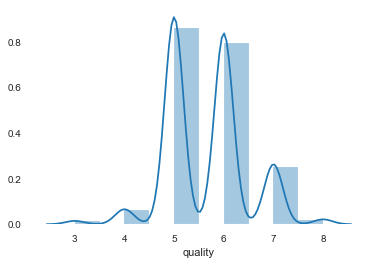

In [12]:
sns.distplot(train.quality, bins = 10)

The data is fairly normally distributed - it seems that the majority of the values are between 5 and 6. 

In [13]:
print(f'''

The difference between the mean {wines.quality.mean():.2f} and median {wines.quality.median():.2f} is: 

{wines.quality.mean() - wines.quality.median():.2f}

This also supports the fact that the data is normally distributed.
 
''')



The difference between the mean 5.64 and median 6.00 is: 

-0.36

This also supports the fact that the data is normally distributed.
 



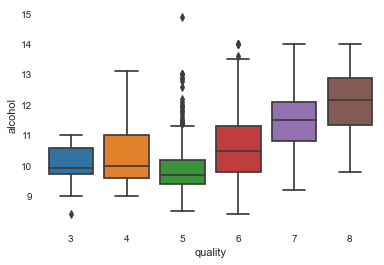

In [14]:
sns.boxplot(x="quality", y="alcohol", data=wines)

When we bin the values, and try to look at the alcohol distribution per quality bin, we actually see that there isn't as much of a difference, although higher quality wines are, on average, much higher alcohol content. An interesting observation is the fact that there are plently of outliers in the medium bin. This tells me that acohol alone is not enough of an indicator of quality.

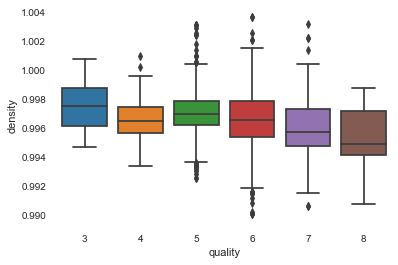

In [15]:
sns.boxplot(x= "quality", y = "density", data = wines)

Density also has a high correlation, but in reality, it seems that there is not much difference in mean. At the same time there are a lot of outliers, which leads me to believe that the data is a bit skewed. Even though there is a negative correlation between these values, it doesn't seem to show too much in the bins. There does seem to be some outliers, but at the moment I will not remove them, because they are not too far from the upper and lower bounds.

In [16]:
scaler, train_scaled, test_scaled = split_scale.min_max_scaler(X_train, X_test)

## Feature Selection

In [17]:
feature_engineering.rfe(X_train, y_train,3)

3 selected features
['volatile acidity', 'chlorides', 'density']


Using RFE for feature selection - we see that the top three choices are `volative_acidity`, `chlorides`, and `density`.

## Modeling with Linear Regression

Since the target variable in this case is a number between 0 and 10, we will experiment using both linear regression and classification models, to see which are more effective.

In [18]:
assert(X_train.shape[0]) == y_train.shape[0]

In [19]:
# We will be storing all the results of the models in a df, to make it easier to compare
predictions = pd.DataFrame({'actual': y_train.quality})
predictions["baseline"] = y_train.quality.mean()

In [20]:
# Using RFE Suggestions

X_1 = train_scaled[["volatile acidity", "density", "chlorides"]]
y_1 = y_train

lm = LinearRegression().fit(X_1, y_1)
predictions["density_volatile_acidity"] = lm.predict(X_1)

In [21]:
# Using all features

X_2 = train_scaled
y_2 = y_train

lm = LinearRegression().fit(X_2, y_2)

predictions["all_features"] = lm.predict(X_2)

In [22]:
predictions.head()

,actual,baseline,density_volatile_acidity,all_features
1076,6,5.631744,6.112384,6.428037
847,6,5.631744,5.307547,5.271420
582,5,5.631744,5.474990,5.235818
172,6,5.631744,5.807063,5.482386
779,5,5.631744,5.609400,5.262947


In [23]:
predictions.apply(lambda col: sklearn.metrics.mean_squared_error(predictions.actual, col))

actual                      0.000000
baseline                    0.648594
density_volatile_acidity    0.519386
all_features                0.410830
dtype: float64

In [24]:
print(f'''
Evaluate all key features: 

MSE = {sklearn.metrics.mean_squared_error(predictions.actual, predictions.all_features):.2}

RMSE = {sqrt(sklearn.metrics.mean_squared_error(predictions.actual, predictions.all_features)):.2}

R-square = {explained_variance_score(predictions.actual, predictions.all_features):.2f}
'''
)


Evaluate all key features: 

MSE = 0.41

RMSE = 0.64

R-square = 0.37



It seems we have a working model, that performs better than the RFE features, and the baseline. We will now see how the classification models work.

# Classification Models

We will now use four different classification models to try to predict the quality of the wine. 

The models we will be using will be: 

1. Logistic Regression
1. Decision Tree
1. Random Forest
1. K-Nearest Neighbors

In [25]:
def return_values(scaler, train, validate, test):
        train_scaled = pd.DataFrame(scaler.transform(train), columns=train.columns.values).set_index([train.index.values])
        validate_scaled = pd.DataFrame(scaler.transform(validate), columns=validate.columns.values).set_index([validate.index.values])
        test_scaled = pd.DataFrame(scaler.transform(test), columns=test.columns.values).set_index([test.index.values])
        return scaler, train_scaled, validate_scaled, test_scaled

def get_data_for_modeling():
    # Data acquire and prep
    wines = pd.read_csv("wine-quality-red.csv")
    wines["mso2"] = wines["free sulfur dioxide"] / (1 + 10** (wines.pH - 1.81))
    wines = wines.drop(columns= "fixed acidity")
    
    # Data split
    train, test = train_test_split(wines, random_state = 123, train_size=.8)
    train, validate = train_test_split(train, random_state = 123, train_size=.75)
    X_train = train.drop(columns=["quality"])
    y_train = train.quality
    X_validate = validate.drop(columns=["quality"])
    y_validate = validate.quality
    X_test = test.drop(columns="quality")
    y_test = test.quality
    
    # Data Scale
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    scaler, train_scaled, validate_scaled, test_scaled = return_values(scaler, X_train, X_validate, X_test)
    
    return train_scaled, y_train, validate_scaled, y_validate, test_scaled, y_test
    

In an effort to avoid data leakage, I have created a function above to let me pull and prep the data. This way, for every model I run, I can do it with "clean data:

## Logistic Regression

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler

In [27]:
# Model
train_scaled, y_train, validate_scaled, y_validate, test_scaled, y_test = get_data_for_modeling()

In [28]:
class_eval = pd.DataFrame({"actual": y_train, "baseline": 5})

In [29]:
train_scaled.head()

,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,mso2
981,0.506849,0.26,0.068966,0.111853,0.169014,0.077739,0.517621,0.401575,0.153374,0.285714,0.129035
1503,0.219178,0.39,0.110345,0.108514,0.070423,0.028269,0.402349,0.606299,0.196319,0.464286,0.027806
456,0.321918,0.39,0.096552,0.138564,0.056338,0.056537,0.626285,0.496063,0.128834,0.339286,0.032791
611,0.178082,0.55,0.124138,0.115192,0.056338,0.035336,0.773128,0.188976,0.104294,0.178571,0.087467
2,0.438356,0.04,0.096552,0.133556,0.197183,0.169611,0.508811,0.409449,0.171779,0.250000,0.146556


In [30]:
logit = LogisticRegression().fit(train_scaled, y_train)
class_eval["logistic_regression"] = logit.predict(train_scaled)

In [31]:
# short eval:

logit.score(validate_scaled, y_validate)

0.596875

In [32]:
labels = sorted(y_train.unique())

pd.DataFrame(confusion_matrix(class_eval.actual, class_eval.logistic_regression), index = labels, columns = labels)

,3,4,5,6,7,8
3,0,0,7,1,0,0
4,0,0,20,4,1,0
5,0,0,318,87,1,0
6,0,0,127,249,10,0
7,0,0,9,92,22,0
8,0,0,0,6,5,0


If we adjust the probabilities - can we improve the accuracy?

In [33]:
logit.predict_proba(X_train)[:,0]

array([2.35824942e-018, 1.43765273e-044, 1.96107577e-012, ...,
       2.75014301e-018, 5.21458242e-147, 1.05157774e-028])

## Decision Tree

In [34]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [35]:
# acquire and prep
train_scaled, y_train, validate_scaled, y_validate, test_scaled, y_test = get_data_for_modeling()

For testing purposes, we will look at different values of `max_depth`.

In [36]:
for i in range(1, 20):
    clf = DecisionTreeClassifier(criterion='entropy', max_depth=i, random_state=123).fit(train_scaled, y_train)
    score = clf.score(validate_scaled, y_validate)
    print(f"Max_deph = {i}, accuracy score = {score:.2%}")

Max_deph = 1, accuracy score = 57.19%
Max_deph = 2, accuracy score = 56.88%
Max_deph = 3, accuracy score = 60.31%
Max_deph = 4, accuracy score = 59.69%
Max_deph = 5, accuracy score = 57.81%
Max_deph = 6, accuracy score = 58.44%
Max_deph = 7, accuracy score = 60.31%
Max_deph = 8, accuracy score = 58.13%
Max_deph = 9, accuracy score = 56.56%
Max_deph = 10, accuracy score = 60.31%
Max_deph = 11, accuracy score = 60.31%
Max_deph = 12, accuracy score = 59.69%
Max_deph = 13, accuracy score = 60.31%
Max_deph = 14, accuracy score = 58.44%
Max_deph = 15, accuracy score = 58.13%
Max_deph = 16, accuracy score = 59.38%
Max_deph = 17, accuracy score = 59.38%
Max_deph = 18, accuracy score = 59.38%
Max_deph = 19, accuracy score = 59.38%


Based on the score above, we see that the highest value we can get is about a 64.84% accuracy, which happens when the `max_depth` is 14.

In [37]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth=14, random_state=123).fit(train_scaled, y_train)
class_eval["decision_tree"] = clf.predict(train_scaled)

In [38]:
# Short eval
train_score = clf.score(train_scaled, y_train)

validate_score = clf.score(validate_scaled, y_validate)

print(f'''
The train score is {train_score}
The validate score is {validate_score}
The difference is {(validate_score - train_score)/ train_score:.2%}
''')


The train score is 0.9989572471324296
The validate score is 0.584375
The difference is -41.50%



In [39]:
labels = sorted(y_train.unique())

pd.DataFrame(confusion_matrix(class_eval.actual, class_eval.decision_tree), index = labels, columns = labels)

,3,4,5,6,7,8
3,8,0,0,0,0,0
4,0,25,0,0,0,0
5,0,0,406,0,0,0
6,0,0,1,385,0,0
7,0,0,0,0,123,0
8,0,0,0,0,0,11


## Random Forest

In [40]:
# acquire and prep
train_scaled, y_train, validate_scaled, y_validate, test_scaled, y_test = get_data_for_modeling()

In [41]:
for i in range(1, 20):
    rf = RandomForestClassifier(random_state= 123, min_samples_leaf = 1, max_depth = i).fit(train_scaled, y_train)
    score = rf.score(validate_scaled, y_validate)
    print(f"Max_deph = {i}, accuracy score = {score:.2%}")

Max_deph = 1, accuracy score = 56.88%
Max_deph = 2, accuracy score = 59.38%
Max_deph = 3, accuracy score = 60.31%
Max_deph = 4, accuracy score = 61.25%
Max_deph = 5, accuracy score = 61.56%
Max_deph = 6, accuracy score = 63.12%
Max_deph = 7, accuracy score = 64.38%
Max_deph = 8, accuracy score = 66.25%
Max_deph = 9, accuracy score = 66.56%
Max_deph = 10, accuracy score = 68.12%
Max_deph = 11, accuracy score = 65.94%
Max_deph = 12, accuracy score = 66.88%
Max_deph = 13, accuracy score = 67.50%
Max_deph = 14, accuracy score = 68.12%
Max_deph = 15, accuracy score = 68.12%
Max_deph = 16, accuracy score = 69.06%
Max_deph = 17, accuracy score = 68.44%
Max_deph = 18, accuracy score = 67.81%
Max_deph = 19, accuracy score = 68.44%


In [42]:
rf, y_pred = model.run_rf(train_scaled, y_train, 1, 17)
class_eval["random_forest"] = y_pred
y_pred = rf.predict(validate_scaled)
accuracy_score, matrix, report = model.accuracy_report(rf, y_pred, y_validate)
print(accuracy_score)
print(matrix)
report

Accuracy on dataset: 0.68
   3  4    5   6   7  8
3  0  0    1   0   0  0
4  1  0   10   4   0  0
5  0  0  117  25   2  0
6  0  0   34  84   3  0
7  0  0    3  16  18  0
8  0  0    0   2   0  0


,3,4,5,6,7,8,accuracy,macro avg,weighted avg
precision,0.0,0.0,0.709091,0.641221,0.782609,0.0,0.684375,0.355487,0.652042
recall,0.0,0.0,0.812500,0.694215,0.486486,0.0,0.684375,0.332200,0.684375
f1-score,0.0,0.0,0.757282,0.666667,0.600000,0.0,0.684375,0.337325,0.662235
support,1.0,15.0,144.000000,121.000000,37.000000,2.0,0.684375,320.000000,320.000000


## KNN

In [43]:
# acquire and prep
train_scaled, y_train, validate_scaled, y_validate, test_scaled, y_test = get_data_for_modeling()

In [44]:
for i in range(1,25):
    knn, y_pred = model.run_knn(train_scaled, y_train, i)
    score = knn.score(validate_scaled, y_validate)
    print(f"Max_deph = {i}, accuracy score = {score:.2%}")

Max_deph = 1, accuracy score = 60.31%
Max_deph = 2, accuracy score = 58.44%
Max_deph = 3, accuracy score = 53.75%
Max_deph = 4, accuracy score = 56.56%
Max_deph = 5, accuracy score = 56.56%
Max_deph = 6, accuracy score = 59.06%
Max_deph = 7, accuracy score = 57.81%
Max_deph = 8, accuracy score = 57.81%
Max_deph = 9, accuracy score = 58.75%
Max_deph = 10, accuracy score = 59.69%
Max_deph = 11, accuracy score = 59.69%
Max_deph = 12, accuracy score = 58.75%
Max_deph = 13, accuracy score = 59.06%
Max_deph = 14, accuracy score = 59.38%
Max_deph = 15, accuracy score = 62.81%
Max_deph = 16, accuracy score = 62.19%
Max_deph = 17, accuracy score = 60.31%
Max_deph = 18, accuracy score = 59.38%
Max_deph = 19, accuracy score = 61.56%
Max_deph = 20, accuracy score = 61.25%
Max_deph = 21, accuracy score = 61.25%
Max_deph = 22, accuracy score = 61.56%
Max_deph = 23, accuracy score = 60.31%
Max_deph = 24, accuracy score = 60.31%


In [45]:
knn, y_pred = model.run_knn(train_scaled, y_train, 16)
class_eval["knn"] = y_pred
y_pred = knn.predict(validate_scaled)
accuracy_score, matrix, report = model.accuracy_report(knn,y_pred, y_validate)
print(accuracy_score)
print(matrix)
report

Accuracy on dataset: 0.62
   3  4    5   6   7  8
3  0  0    1   0   0  0
4  0  0    6   8   1  0
5  0  0  109  33   2  0
6  0  0   38  79   4  0
7  0  0    5  21  11  0
8  0  0    0   2   0  0


,3,4,5,6,7,8,accuracy,macro avg,weighted avg
precision,0.0,0.0,0.685535,0.552448,0.611111,0.0,0.621875,0.308182,0.588045
recall,0.0,0.0,0.756944,0.652893,0.297297,0.0,0.621875,0.284522,0.621875
f1-score,0.0,0.0,0.719472,0.598485,0.400000,0.0,0.621875,0.286326,0.596314
support,1.0,15.0,144.000000,121.000000,37.000000,2.0,0.621875,320.000000,320.000000


## Evaluate

Lets see how to models compare to each other

In [46]:
for i in range(0,6):
    score = pd.DataFrame(classification_report(class_eval.actual, class_eval.iloc[:,i], output_dict=True))
    accuracy_score = score.accuracy[0]
    print(f"{class_eval.columns[i]} accuracy = {accuracy_score:.0%}")

actual accuracy = 100%
baseline accuracy = 42%
logistic_regression accuracy = 61%
decision_tree accuracy = 100%
random_forest accuracy = 100%
knn accuracy = 64%


In [47]:
# How does the validate data sets perform?

# Modeling Phase II 

Although the models are working - there might be a way to improve their performance by actually merging the target variables by their means, so that there are less possible outcomes.

* Wines with scores 0 - 3 = 0
* Wines with scores 4 - 7 = 1
* Wines with scores 8 - 10 = 2

In [48]:
def return_values_modeling(scaler, train, validate, test):
        train_scaled = pd.DataFrame(scaler.transform(train), columns=train.columns.values).set_index([train.index.values])
        validate_scaled = pd.DataFrame(scaler.transform(validate), columns=validate.columns.values).set_index([validate.index.values])
        test_scaled = pd.DataFrame(scaler.transform(test), columns=test.columns.values).set_index([test.index.values])
        return scaler, train_scaled, validate_scaled, test_scaled

def get_data_for_modeling_2():
    # Data acquire and prep
    wines = pd.read_csv("wine-quality-red.csv")
    wines["mso2"] = wines["free sulfur dioxide"] / (1 + 10** (wines.pH - 1.81))
    wines = wines.drop(columns= "fixed acidity")
    wines['value'] = [2 if each > 6 else 1 if ((each > 4) and (each < 7)) else 0 for each in wines['quality']]
    wines.drop(columns="quality", inplace = True)
    
    # Data split
    train, test = train_test_split(wines, random_state = 123, train_size=.8)
    train, validate = train_test_split(train, random_state = 123, train_size=.75)
    X_train = train.drop(columns=["value"])
    y_train = train.value
    X_validate = validate.drop(columns=["value"])
    y_validate = validate.value
    X_test = test.drop(columns="value")
    y_test = test.value
    
    # Data Scale
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    scaler, train_scaled, validate_scaled, test_scaled = return_values_modeling(scaler, X_train, X_validate, X_test)
    
    return train_scaled, y_train, validate_scaled, y_validate, test_scaled, y_test

In [49]:
# acquire and prep
train_scaled, y_train, validate_scaled, y_validate, test_scaled, y_test = get_data_for_modeling_2()

In [50]:
train_scaled.shape

(959, 11)

In [51]:
y_train.value_counts()

1    792
2    134
0     33
Name: value, dtype: int64

In [52]:
y_train.mode()[0]

1

In [53]:
class_eval_2 = pd.DataFrame({"actual": y_train})
class_eval_2["baseline"] = y_train.mode()[0]

In [54]:
class_eval_2

,actual,baseline
981,1,1
1503,1,1
456,1,1
611,1,1
2,1,1
...,...,...
862,1,1
998,1,1
1057,1,1
1345,1,1


## Logistic Regression

In [55]:
logit = LogisticRegression().fit(train_scaled, y_train)
class_eval_2["logistic_regression_2"] = logit.predict(train_scaled)

In [56]:
logit, y_pred = model.run_lg(train_scaled, y_train)
accuracy_score, matrix, report = model.accuracy_report(logit, y_pred, y_train)

print(accuracy_score)
print(matrix)
report

Accuracy on dataset: 0.84
   0    1   2
0  0   32   1
1  0  775  17
2  0  101  33


,0,1,2,accuracy,macro avg,weighted avg
precision,0.0,0.853524,0.647059,0.842544,0.500194,0.795305
recall,0.0,0.978535,0.246269,0.842544,0.408268,0.842544
f1-score,0.0,0.911765,0.356757,0.842544,0.422840,0.802839
support,33.0,792.000000,134.000000,0.842544,959.000000,959.000000


In [57]:
# Short eval on validate df
y_pred = logit.predict(validate_scaled)
accuracy_score, matrix, report = model.accuracy_report(logit, y_pred, y_validate)
print(accuracy_score)
print(matrix)
report

Accuracy on dataset: 0.86
   0    1   2
0  0   16   0
1  0  262   3
2  0   27  12


,0,1,2,accuracy,macro avg,weighted avg
precision,0.0,0.859016,0.800000,0.85625,0.553005,0.808873
recall,0.0,0.988679,0.307692,0.85625,0.432124,0.856250
f1-score,0.0,0.919298,0.444444,0.85625,0.454581,0.815461
support,16.0,265.000000,39.000000,0.85625,320.000000,320.000000


## Decision Tree

In [58]:
# acquire and prep
train_scaled, y_train, validate_scaled, y_validate, test_scaled, y_test = get_data_for_modeling_2()

In [59]:
for i in range(1,25):
    clf, y_pred = model.run_clf(train_scaled, y_train, i)
    y_pred = clf.predict(validate_scaled)
    accuracy_score, matrix, report = model.accuracy_report(clf, y_pred, y_validate)
    print(f'{i} = {report.accuracy[0]:.2f}')

1 = 0.83
2 = 0.83
3 = 0.83
4 = 0.83
5 = 0.85
6 = 0.86
7 = 0.84
8 = 0.85
9 = 0.84
10 = 0.84
11 = 0.83
12 = 0.83
13 = 0.83
14 = 0.83
15 = 0.83
16 = 0.83
17 = 0.83
18 = 0.83
19 = 0.83
20 = 0.83
21 = 0.83
22 = 0.83
23 = 0.83
24 = 0.83


In [60]:
clf, y_pred = model.run_clf(train_scaled, y_train, 6)
class_eval_2["decision_tree_2"] = y_pred

In [61]:
accuracy_score, matrix, report = model.accuracy_report(clf, y_pred, y_train)
print(accuracy_score)
print(matrix)
report

Accuracy on dataset: 0.91
    0    1   2
0  10   23   0
1   1  776  15
2   0   46  88


,0,1,2,accuracy,macro avg,weighted avg
precision,0.909091,0.918343,0.854369,0.911366,0.893934,0.909086
recall,0.303030,0.979798,0.656716,0.911366,0.646515,0.911366
f1-score,0.454545,0.948076,0.742616,0.911366,0.715079,0.902384
support,33.000000,792.000000,134.000000,0.911366,959.000000,959.000000


In [62]:
y_pred = clf.predict(validate_scaled)
accuracy_score, matrix, report = model.accuracy_report(clf, y_pred, y_validate)
print(accuracy_score)
print(matrix)
report

Accuracy on dataset: 0.86
   0    1   2
0  2   14   0
1  2  257   6
2  0   23  16


,0,1,2,accuracy,macro avg,weighted avg
precision,0.500,0.874150,0.727273,0.859375,0.700474,0.837542
recall,0.125,0.969811,0.410256,0.859375,0.501689,0.859375
f1-score,0.200,0.919499,0.524590,0.859375,0.548030,0.835395
support,16.000,265.000000,39.000000,0.859375,320.000000,320.000000


... So we got 100% accuracy on the validate data... that's pretty cool

## Random Forest

In [63]:
# acquire and prep
train_scaled, y_train, validate_scaled, y_validate, test_scaled, y_test = get_data_for_modeling_2()

In [64]:
for i in range(1,25):
    rf, y_pred = model.run_rf(train_scaled, y_train, 1, i)
    y_pred = rf.predict(validate_scaled)
    accuracy_score, matrix, report = model.accuracy_report(rf, y_pred, y_validate)
    print(f"{i} = {report.accuracy[0]:.2f}")

1 = 0.83
2 = 0.83
3 = 0.85
4 = 0.85
5 = 0.85
6 = 0.86
7 = 0.86
8 = 0.86
9 = 0.86
10 = 0.87
11 = 0.87
12 = 0.87
13 = 0.88
14 = 0.87
15 = 0.87
16 = 0.87
17 = 0.87
18 = 0.87
19 = 0.88
20 = 0.87
21 = 0.87
22 = 0.87
23 = 0.87
24 = 0.87


In [65]:
rf, y_pred = model.run_rf(train_scaled, y_train, 1, 10)
class_eval_2["random_forest_2"] = y_pred

In [66]:
accuracy_score, matrix, report = model.accuracy_report(rf, y_pred, y_train)
print(accuracy_score)
print(matrix)
report

Accuracy on dataset: 0.97
    0    1    2
0  22   11    0
1   0  792    0
2   0   13  121


,0,1,2,accuracy,macro avg,weighted avg
precision,1.000000,0.970588,1.000000,0.974974,0.990196,0.975710
recall,0.666667,1.000000,0.902985,0.974974,0.856551,0.974974
f1-score,0.800000,0.985075,0.949020,0.974974,0.911365,0.973668
support,33.000000,792.000000,134.000000,0.974974,959.000000,959.000000


In [67]:
y_pred = rf.predict(validate_scaled)
accuracy_score, matrix, report = model.accuracy_report(rf, y_pred, y_validate)
print(accuracy_score)
print(matrix)
report

Accuracy on dataset: 0.87
   0    1   2
0  1   15   0
1  0  261   4
2  0   24  15


,0,1,2,accuracy,macro avg,weighted avg
precision,1.000000,0.870000,0.789474,0.865625,0.886491,0.866686
recall,0.062500,0.984906,0.384615,0.865625,0.477340,0.865625
f1-score,0.117647,0.923894,0.517241,0.865625,0.519594,0.834021
support,16.000000,265.000000,39.000000,0.865625,320.000000,320.000000


## KNN

In [68]:
# acquire and prep
train_scaled, y_train, validate_scaled, y_validate, test_scaled, y_test = get_data_for_modeling_2()

In [69]:
for i in range(1,25):
    knn, y_pred = model.run_knn(train_scaled, y_train, i)
    accuracy_score, matrix, report = model.accuracy_report(knn, y_pred, y_train)
    y_pred_2 = knn.predict(validate_scaled)
    accuracy_score_2, matrix_2, report_2 = model.accuracy_report(knn, y_pred_2, y_validate)
    print(f"{i} = {report.accuracy[0]:.2f}, eval = {report_2.accuracy[0]:.2f}")

1 = 1.00, eval = 0.84
2 = 0.91, eval = 0.82
3 = 0.91, eval = 0.82
4 = 0.88, eval = 0.86
5 = 0.88, eval = 0.84
6 = 0.87, eval = 0.84
7 = 0.87, eval = 0.84
8 = 0.86, eval = 0.84
9 = 0.86, eval = 0.85
10 = 0.86, eval = 0.85
11 = 0.86, eval = 0.84
12 = 0.86, eval = 0.84
13 = 0.85, eval = 0.84
14 = 0.85, eval = 0.84
15 = 0.84, eval = 0.85
16 = 0.85, eval = 0.84
17 = 0.84, eval = 0.84
18 = 0.85, eval = 0.84
19 = 0.85, eval = 0.84
20 = 0.85, eval = 0.84
21 = 0.85, eval = 0.85
22 = 0.85, eval = 0.85
23 = 0.84, eval = 0.85
24 = 0.85, eval = 0.85


In [70]:
knn, y_pred = model.run_knn(train_scaled, y_train, 4)
class_eval_2["knn_2"] = y_pred

In [71]:
accuracy_score, matrix, report = model.accuracy_report(knn, y_pred, y_train)
print(accuracy_score)
print(matrix)
report

Accuracy on dataset: 0.88
   0    1   2
0  7   24   2
1  3  778  11
2  0   73  61


,0,1,2,accuracy,macro avg,weighted avg
precision,0.700000,0.889143,0.824324,0.882169,0.804489,0.873577
recall,0.212121,0.982323,0.455224,0.882169,0.549889,0.882169
f1-score,0.325581,0.933413,0.586538,0.882169,0.615178,0.864029
support,33.000000,792.000000,134.000000,0.882169,959.000000,959.000000


In [72]:
y_pred = knn.predict(validate_scaled)
accuracy_score, matrix, report = model.accuracy_report(knn, y_pred, y_validate)
print(accuracy_score)
print(matrix)
report

Accuracy on dataset: 0.86
   0    1   2
0  3   13   0
1  3  259   3
2  0   27  12


,0,1,2,accuracy,macro avg,weighted avg
precision,0.500000,0.866221,0.800000,0.85625,0.722074,0.839839
recall,0.187500,0.977358,0.307692,0.85625,0.490850,0.856250
f1-score,0.272727,0.918440,0.444444,0.85625,0.545204,0.828386
support,16.000000,265.000000,39.000000,0.85625,320.000000,320.000000


In [73]:
pd.DataFrame(classification_report(class_eval_2.actual, class_eval_2.knn_2, output_dict=True)).accuracy[0]

0.8821689259645464

In [74]:
# Compare the different models

for i in range(0,6):
    accuracy = pd.DataFrame(classification_report(class_eval_2.actual, class_eval_2.iloc[:,i], output_dict=True)).accuracy[0]
    print(f'{class_eval_2.columns[i]} accuracy score = {accuracy:.2f}')

actual accuracy score = 1.00
baseline accuracy score = 0.83
logistic_regression_2 accuracy score = 0.84
decision_tree_2 accuracy score = 0.91
random_forest_2 accuracy score = 0.97
knn_2 accuracy score = 0.88


In [75]:
# Just realized there was a mistake - and during the modeling phase ii, we actually leaked the target vareiable to he models
# which is why there were preforming so well. 

# Need to redo phase II and find a good model.

The models do significantly better predicting quality when we look at the mean of quality. The next step I would like to try is to then isolate the wines based on their mean score - and then we can run individual models for each individual subgroup. 

SO this is what the plan could look like: 

1. Data comes in without labels
2. Use random forest 2 to predict if they fall into category 0, 1 or 2
3. Divde the data based on each category
4. Run each subset through a new model to predict the final quality of the wine

# Modeling Phase III

In [76]:
def return_values_modeling(scaler, train, validate, test):
        train_scaled = pd.DataFrame(scaler.transform(train), columns=train.columns.values).set_index([train.index.values])
        validate_scaled = pd.DataFrame(scaler.transform(validate), columns=validate.columns.values).set_index([validate.index.values])
        test_scaled = pd.DataFrame(scaler.transform(test), columns=test.columns.values).set_index([test.index.values])
        return scaler, train_scaled, validate_scaled, test_scaled

def get_data_for_modeling_3():
    # Data acquire and prep
    wines = pd.read_csv("wine-quality-red.csv")
    wines["mso2"] = wines["free sulfur dioxide"] / (1 + 10** (wines.pH - 1.81))
    wines = wines.drop(columns= "fixed acidity")
    wines['value'] = [2 if each > 6 else 1 if ((each > 4) and (each < 7)) else 0 for each in wines['quality']]
    
    # Data split
    train, test = train_test_split(wines, random_state = 123, train_size=.8)
    train, validate = train_test_split(train, random_state = 123, train_size=.75)
    X_train = train.drop(columns=["value", "quality"])
    y_train = train[["value", "quality"]]
    X_validate = validate.drop(columns=["value", "quality"])
    y_validate = validate[["value", "quality"]]
    X_test = test.drop(columns= ["value", "quality"])
    y_test = test[["value", "quality"]]
    
    # Data Scale
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    scaler, train_scaled, validate_scaled, test_scaled = return_values_modeling(scaler, X_train, X_validate, X_test)
    
    return train_scaled, y_train, validate_scaled, y_validate, test_scaled, y_test

# Random Forest

In [77]:
train_scaled, y_train, validate_scaled, y_validate, test_scaled, y_test = get_data_for_modeling_2()

In [78]:
train_scaled

,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,mso2
981,0.506849,0.26,0.068966,0.111853,0.169014,0.077739,0.517621,0.401575,0.153374,0.285714,0.129035
1503,0.219178,0.39,0.110345,0.108514,0.070423,0.028269,0.402349,0.606299,0.196319,0.464286,0.027806
456,0.321918,0.39,0.096552,0.138564,0.056338,0.056537,0.626285,0.496063,0.128834,0.339286,0.032791
611,0.178082,0.55,0.124138,0.115192,0.056338,0.035336,0.773128,0.188976,0.104294,0.178571,0.087467
2,0.438356,0.04,0.096552,0.133556,0.197183,0.169611,0.508811,0.409449,0.171779,0.250000,0.146556
...,...,...,...,...,...,...,...,...,...,...,...
862,0.205479,0.32,0.124138,0.091820,0.084507,0.067138,0.455947,0.393701,0.042945,0.357143,0.067743
998,0.493151,0.34,0.034483,0.063439,0.042254,0.014134,0.401615,0.299213,0.067485,0.125000,0.048583
1057,0.205479,0.25,0.206897,0.153589,0.380282,0.296820,0.570485,0.322835,0.122699,0.125000,0.359114
1345,0.219178,0.24,0.096552,0.085142,0.126761,0.077739,0.444934,0.401575,0.098160,0.321429,0.097564


In [87]:
for i in range(1,25):
    rf, y_pred = model.run_rf(train_scaled, y_train, 1, i)
    y_pred = rf.predict(validate_scaled)
    accuracy_score, matrix, report = model.accuracy_report(rf, y_pred, y_validate)
    print(f"{i} = {report.accuracy[0]:.2f}")

ValueError: multiclass-multioutput is not supported

In [81]:
# acquire and prep
train_scaled, y_train, validate_scaled, y_validate, test_scaled, y_test = get_data_for_modeling_3()
y_train_1 = y_train.value
y_validate_1 = y_validate.value

In [88]:
rf, y_pred = model.run_rf(train_scaled, y_train_1, 1, 13)
train_scaled["value"] = y_pred

In [89]:
accuracy_score, matrix, report = model.accuracy_report(rf, y_pred, y_train_1)
print(accuracy_score)
print(matrix)
report

Accuracy on dataset: 0.99
    0    1    2
0  30    3    0
1   0  792    0
2   0    5  129


,0,1,2,accuracy,macro avg,weighted avg
precision,1.000000,0.990000,1.000000,0.991658,0.996667,0.991741
recall,0.909091,1.000000,0.962687,0.991658,0.957259,0.991658
f1-score,0.952381,0.994975,0.980989,0.991658,0.976115,0.991555
support,33.000000,792.000000,134.000000,0.991658,959.000000,959.000000


In [90]:
# We will start with value == 0
train_scaled_0 = train_scaled[train_scaled.value == 0]
y_train_0 = y_train[y_train.value == 0].quality
train_scaled_0.drop(columns="value", inplace=True)


rf, y_pred = model.run_rf(train_scaled_0, y_train_0, 1, 9)


ValueError: Number of labels=33 does not match number of samples=30

# Conclusion